In [1230]:
import json
import re
import pandas as pd
from functools import partial
from pathlib import Path
import numpy as np
from scipy.io import wavfile
from IPython.display import Audio, display
from scipy import signal

TRAIN_DIR = Path('../data/raw/nsynth-train/')
TEST_DIR = Path('../data/raw/nsynth-test/')

def load_piano(show_uniques=False):
    examples = json.load(open(TRAIN_DIR/'examples.json'))
    instruments = pd.Series(list(examples.keys()))
    piano = Path(instruments[instruments.str.startswith('keyboard_acoustic')].iloc[27] + '.wav')
    
    if show_uniques:
        re_find_instrument = partial(re.findall, '^.*?\d')
        unique_instruments = instruments.apply(re_find_instrument).str[0].str[:-2].unique()
        print(unique_instruments)

    return piano

def load_guitar():
    examples = json.load(open(TEST_DIR/'examples.json'))
    instruments = pd.Series(list(examples.keys()))
    guitar = Path(instruments[instruments.str.startswith('guitar_acoustic')].iloc[6] + '.wav')
    return guitar

def load_audio(path):
    # Load
    sampling_rate, data = wavfile.read(path)
    plt.figure(figsize=(10, 4))
    length = data.shape[0] / sampling_rate
    # Plot
    time = np.linspace(0., length, data.shape[0])
    plt.plot(time, data)
    plt.xlim(time.min(), time.max())
    plt.ylabel('Amplitude')
    plt.xlabel('Time (s)');
    plt.tight_layout()
    plt.show()
    display(Audio(data[10000:], rate=sampling_rate))
    # Return
    return data, sampling_rate, length

In [1268]:
from mel import pretty_spectrogram, invert_pretty_spectrogram
from mel import create_mel_filter, make_mel, mel_to_spectrogram

def plot_spectrogram(spectrogram, title):
    """
    Plots a spectrogram
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
    cax = ax.matshow(
        spectrogram.T,
        interpolation="nearest",
        aspect="auto",
        cmap=plt.cm.afmhot,
        origin="lower",
    )
    fig.colorbar(cax)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def audio_to_spectrogram(data, fft_size=50000, time_intervals=1, spec_thresh=4):
    """
    Stolen from: https://timsainburg.com/python-mel-compression-inversion.html

    Args:
        fft_size: window size for the FFT
        time_intervals: how many intervals to slide the window along (in time)   
    
    """
    # Params
    step_size = fft_size // time_intervals
    # Create spectrogram
    wav_spectrogram = pretty_spectrogram(
        data.astype("float64"),
        fft_size=fft_size,
        step_size=step_size,
        log=True,
        thresh=spec_thresh,
    )
    # Plot
    plot_spectrogram(wav_spectrogram, 'Original spectrogram')
    return wav_spectrogram

def spectrogram_to_audio(wav_spectrogram, sampling_rate, fft_size=50000, time_intervals=1):
    """
    Convert spectrogram to audio
    """
    # Params
    step_size = fft_size // time_intervals
    # Recover audio
    recovered_audio = invert_pretty_spectrogram(
        wav_spectrogram, fft_size=fft_size, step_size=step_size, log=True, n_iter=10
    )
    display(Audio(recovered_audio, rate=sampling_rate))

In [1330]:
def get_harmonic_groups(spectrogram):
    """
    Create groups of harmonic frequencies to unwrap the spectrogram
    """
    max_freq = spectrogram.shape[1]
    harmonic_groups = []
    for freq in list(range(1, max_freq//2, 2)):
        neighbours = []
        i = 0
        next_freq = freq
        while next_freq <= max_freq+1:
            neighbours.append(next_freq-1)
            i+=1
            next_freq = freq * (2**i)
        harmonic_groups.append(neighbours)
    return harmonic_groups

def convolve_spectrogram(spectrogram):
    """
    Unwrap the spectrogram_slice, apply 1D conv and wrap it back up
    """
    harmonic_groups = get_harmonic_groups(spectrogram)

    # Iterate
    spectrogram_conv = np.ones(spectrogram.shape)[:, ::2] # * -8
    for t in range(spectrogram.shape[0]):
        # Time slice to apply convolution to
        spectrogram_slice = spectrogram[t]
        # Convolution mask
        mask = [1, 1]
        # Convolution result
        harmonic_convs = []
        # Convolve each group of harmonics
        for group in harmonic_groups:
            harmonic_amplitudes = spectrogram_slice[group]
            harmonic_convs = np.convolve(mask, harmonic_amplitudes, mode='valid')
            spectrogram_conv[t, group[:-1]] = harmonic_convs
    # Plot
    plot_spectrogram(spectrogram_conv, 'Convolved spectrogram')
    return spectrogram_conv

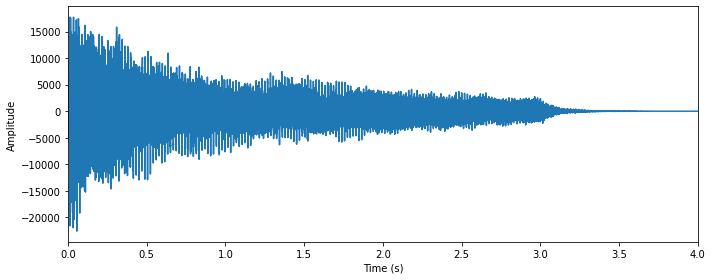

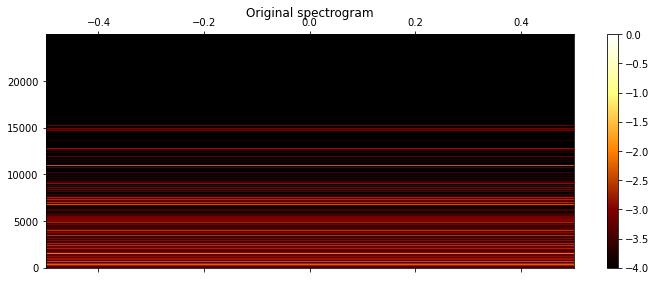

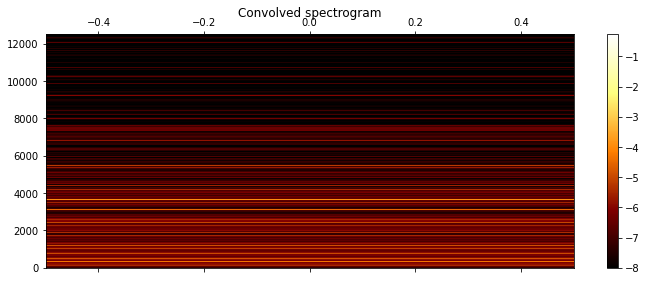

In [1332]:
piano = load_piano()
data, sampling_rate, length = load_audio(path=TRAIN_DIR/'audio'/piano.name)

wav_spectrogram = audio_to_spectrogram(data)
spectrogram_to_audio(wav_spectrogram, sampling_rate)

spectrogram_conv = convolve_spectrogram(wav_spectrogram)
spectrogram_to_audio(spectrogram_conv, sampling_rate, fft_size=25000)

In [1218]:
# # Generate the mel filters
# mel_filter, mel_inversion_filter = create_mel_filter(
#     fft_size=fft_size,
#     n_freq_components=n_mel_freq_components,
#     start_freq=start_freq,
#     end_freq=end_freq,
# )

# def spectrogram_to_mel(wav_spectrogram, fft_size=50000, n_mel_freq_components=64,
#                        start_freq=0, end_freq=16000, shorten_factor=1):
#     # Convert spectrogram to mel
#     mel_spectrogram = make_mel(wav_spectrogram, mel_filter, shorten_factor=shorten_factor)
#     # Plot the compressed spectrogram
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
#     cax = ax.matshow(
#         mel_spectrogram.astype("float32"),
#         interpolation="nearest",
#         aspect="auto",
#         cmap=plt.cm.afmhot,
#         origin="lower",
#     )
#     fig.colorbar(cax)
#     plt.title("Mel Spectrogram")
#     return mel_spectrogram 

# def mel_to_audio(mel_spectrogram, fft_size=50000, spec_thresh=4, shorten_factor=1, time_intervals=4):
#     # Params
#     step_size = fft_size // time_intervals
#     # Convert mel to spectrogram
#     mel_inverted_spectrogram = mel_to_spectrogram(
#         mel_spectrogram,
#         mel_inversion_filter,
#         spec_thresh=spec_thresh,
#         shorten_factor=shorten_factor,
#     )
#     # Recover audio
#     inverted_mel_audio = invert_pretty_spectrogram(
#         np.transpose(mel_inverted_spectrogram),
#         fft_size=fft_size,
#         step_size=step_size,
#         log=True,
#         n_iter=10,
#     )
#     plt.show()
#     display(Audio(recovered_audio, rate=sampling_rate))

In [1219]:
# mel_spectrogram = spectrogram_to_mel(wav_spectrogram)
# mel_to_audio(mel_spectrogram)